In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from semopy import Model, calc_stats, semplot, report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import pingouin as pg

In [2]:
df = pd.read_spss('C:\\data\\education\\한국아동청소년행복지수조사\\kor_data_20210010.sav')
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q512,q513,q514,q52,q53,q5411,q5412,q5421,q5422,wt
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,해당 없음,차이 없음,차이 없음,28.0,그대로다,NaN,NaN,NaN,NaN,0.250048
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,20.0,그대로다,NaN,NaN,NaN,NaN,0.250048
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,30.0,그대로다,NaN,NaN,NaN,NaN,0.250048


In [3]:
df['q4812'].value_counts()

q4812
전혀 그렇지 않다    1959
조금 그렇다       1018
보통이다          952
별로 그렇지 않다     945
매우 그렇다        502
Name: count, dtype: int64

In [4]:
# df = df[df['school'] == '고등학생']
# df.head(3)

In [5]:
len(df)

5376

In [6]:
def null0(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    return df

In [7]:
def encoding(df, columns, category_map): 
    df[columns] = df[columns].replace(category_map)
    return df

category4_map = {
    '전혀 그렇지 않다': 0,
    '그렇지 않다': 1,
    '그렇다': 2,
    '매우 그렇다': 3
}
category5_map = {
    '전혀 그렇지 않다': 0,
    '별로 그렇지 않다': 1,
    '보통이다' : 2,
    '조금 그렇다': 3,
    '매우 그렇다': 4
}
reverse_category5_map = {
    '전혀 그렇지 않다': 4,
    '별로 그렇지 않다': 3,
    '보통이다' : 2,
    '조금 그렇다': 1,
    '매우 그렇다': 0
}
how_serious_map = {
    '전혀 심각하지 않다' : 0,
    '별로 심각하지 않다' : 1,
    '보통이다' : 2,
    '약간 심각한 편이다' : 3,
    '매우 심각하다' : 4
}
how_often_map = {
'경험이 전혀 없거나 거의 없었다' : 2,
'1년에 몇 번 있었다' : 1,
'한 달에 몇 번 있었다' : 0,
'일주일에 한번 이상 있었다' : 0 
}
happy_map = {
'매우 행복하다' : 4,
'대체로 행복한 편이다' : 3,
'모르겠다' : 2,
'별로 행복하지 않은 편이다' : 1,
'전혀 행복하지 않다' : 0
}
how_happy_map = {
'매우 행복하다' : 4,
'약간 행복하다' : 3,
'보통이다' : 2,
'약간 불행하다' : 1,
'매우 불행하다' : 0
}
yes_or_no_map = {
'예' : 1,
'아니오' : 0
}
is_or_not_map = {
    '있다' : 1,
    '없다' : 0
}
is_or_not_map2 = {
    '있다' : 2,
    '없다' : 1
}
how_much_is_map = {
    '전혀 없다' : 0,
    '1~2번 있다' : 1,
    '3~4번 있다' : 2,
    '5번 이상 있다' : 2
}
how_high_map = {
    '상의 상' : 2,
    '상의 하': 2,
    '중의 상': 1,
    '중의 하': 1,
    '하의 상': 0, 
    '하의 하': 0
}

In [8]:
def time_min(df, hour_column, minute_column):
    # 시간과 분 열의 결측값을 0으로 채움
    df[hour_column] = df[hour_column].fillna(0)
    df[minute_column] = df[minute_column].fillna(0)
    
    # 데이터 타입을 float로 변환
    df[hour_column] = df[hour_column].astype(float)
    df[minute_column] = df[minute_column].astype(float)

    # 총 분 계산
    df['pri_edu_time'] = df[hour_column] * 60 + df[minute_column]
    return df

In [9]:
def not_applicable(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '보통이다'})
    return df
def applicable_is_the_worst(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '전혀 그렇지 않다'})
    return df
def applicable_is_the_best(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '매우 그렇다'})
    return df

In [10]:
def weighted_cov(X, weights):
    average = np.average(X, axis=0, weights=weights)
    X_centered = X - average
    cov_matrix = np.dot((X_centered * weights[:, None]).T, X_centered) / (weights.sum() - 1)
    return cov_matrix

In [11]:
def calculate_covariance(df, observed_vars):
    data_for_cov = df[observed_vars].apply(pd.to_numeric, errors='coerce')
    weights = df['wt'].to_numpy()
    w_cov = weighted_cov(data_for_cov.to_numpy(), weights)
    return pd.DataFrame(w_cov, index=observed_vars, columns=observed_vars)

In [12]:
def compute_vif(df, observed_vars):
    X = df[observed_vars].apply(pd.to_numeric, errors='coerce').dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [13]:
def fit_sem_model(model, df, w_cov_df):
    model.fit(df, cov=w_cov_df)
    return model

In [14]:
def calculate_bmi(df, height, weight):
    df[height] = pd.to_numeric(df[height], errors='coerce')
    df[weight] = pd.to_numeric(df[weight], errors='coerce')
    
    df['bmi'] = df[weight] / ((df[height] / 100) ** 2)
    df['bmi'] = df['bmi'].round(2)
    return df

In [15]:
# 표준화 계수 계산 함수
def standardize_estimates(df, data):
    std_estimates = []
    for _, row in df.iterrows():
        if row['op'] == '~':  # 회귀 계수
            try:
                x_std = np.std(data[row['rhs']], ddof=1)
                y_std = np.std(data[row['lhs']], ddof=1)
                std_beta = row['Estimate'] * (x_std / y_std)
                std_estimates.append(std_beta)
            except KeyError:
                std_estimates.append(np.nan)
        elif row['op'] == '=~':  # 요인 부하량
            try:
                x_std = np.std(data[row['rhs']], ddof=1)
                std_estimates.append(row['Estimate'] * x_std)
            except KeyError:
                std_estimates.append(np.nan)
        else:
            std_estimates.append(np.nan)
    df['std_estimate'] = std_estimates
    return df

# 학업압박

In [16]:
df_edu = df[['q071','q072', 'q073', 'q074'] + ['q485', 'q486', 'q487', 'q488']]
df_edu = null0(df_edu)

df_edu = encoding(df_edu, ['q071', 'q072', 'q073', 'q074'], category4_map)
df_edu = encoding(df_edu, ['q485', 'q486','q487', 'q488'], category5_map)

In [17]:
scaler = MinMaxScaler()
df_edu[['q071', 'q072', 'q073', 'q074', 'q485', 'q486','q487', 'q488']] = scaler.fit_transform(df_edu[['q071', 'q072', 'q073', 'q074', 'q485', 'q486','q487', 'q488']])

In [18]:
model_desc = """
academic_stress =~ q072 + q073
exam_anxiety =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety
academic_stress ~~ exam_anxiety
"""

In [19]:
df_edu['wt'] = df['wt']
observed_vars = ['q072', 'q073', 'q485', 'q486', 'q487', 'q488']
w_cov_df = calculate_covariance(df_edu, observed_vars)

적합도 지표:
                       Value
DoF                6.000000
DoF Baseline      15.000000
chi2             241.352913
chi2 p-value       0.000000
chi2 Baseline  14606.987426
CFI                0.983871
GFI                0.983477
AGFI               0.958692
NFI                0.983477
TLI                0.959678
RMSEA              0.085427
AIC               29.910211
BIC              128.755709
LogLik             0.044895 


모수 추정치:
                  lval  op               rval  Estimate  Std. Err     z-value  \
0     academic_stress   ~  academic_pressure  1.000000         -           -   
1        exam_anxiety   ~  academic_pressure  0.015159  0.000056  270.468469   
2                q072   ~    academic_stress  1.000000         -           -   
3                q073   ~    academic_stress  0.833664  0.017369   47.997865   
4                q485   ~       exam_anxiety  1.000000         -           -   
5                q486   ~       exam_anxiety  1.009905  0.016667   60.591936   

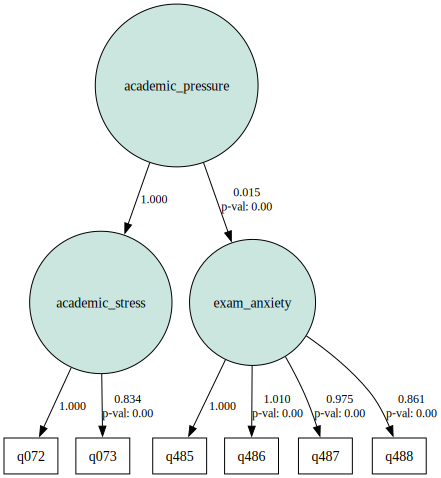

In [20]:
model = Model(model_desc)
model = fit_sem_model(model, df_edu, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\academic_pressure.png')

In [22]:
factor_scores = model.predict_factors(df_edu)

df["academic_pressure"] = factor_scores["academic_pressure"]
df['academic_stress'] = factor_scores["academic_stress"]
df['exam_anxiety'] = factor_scores["exam_anxiety"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure academic_stress exam_anxiety  
0         -0.374990       -0.473441     0.002692  
1         -0.102685       -0.232

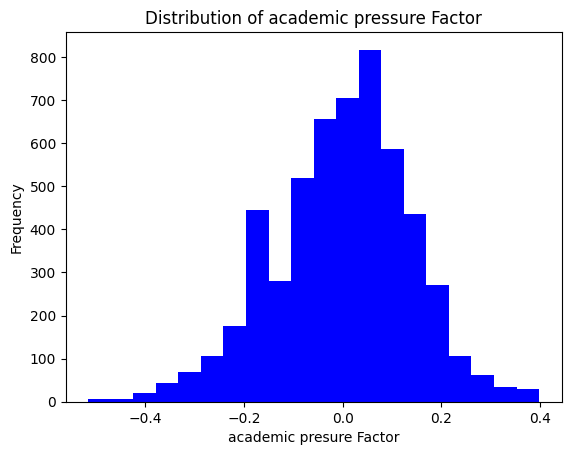

In [23]:
plt.hist(df["academic_pressure"], bins=20, color='blue')
plt.title("Distribution of academic pressure Factor")
plt.xlabel("academic presure Factor")
plt.ylabel("Frequency")
plt.show()

# 인간 관계

In [24]:
df_rel = df[['q05','q134', 'q136', 'q489','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225', 'q132']]
df_rel.columns

Index(['q05', 'q134', 'q136', 'q489', 'q061', 'q062', 'q161', 'q162', 'q163',
       'q164', 'q171', 'q172', 'q173', 'q174', 'q224', 'q225', 'q132'],
      dtype='object')

In [25]:
df_rel['q172'].value_counts()

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

In [120]:
df_rel['q05'].value_counts()

q05
1.00    2052
0.75    1530
0.50    1361
0.25     297
0.00     136
Name: count, dtype: int64

In [27]:
df_rel = not_applicable(df_rel, ['q171','q172','q162', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = applicable_is_the_best(df_rel, ['q132', 'q134'])
df_rel = applicable_is_the_worst(df_rel, ['q136'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132', 'q134', 'q489'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)

,q05,q134,q136,q489,q061,q062,q161,q162,q163,q164,q171,q172,q173,q174,q224,q225,q132
0,1.00,1.0,1.0,1.0,0.75,0.00,1.0,1.0,1.00,0.25,1.0,1.0,1.00,0.25,0.50,0.25,1.0
1,0.75,1.0,1.0,1.0,0.75,0.25,1.0,1.0,1.00,0.75,1.0,1.0,1.00,0.75,0.75,0.75,1.0
2,1.00,1.0,0.0,0.5,1.00,1.00,1.0,1.0,0.75,0.75,0.5,0.5,0.75,0.50,0.50,1.00,1.0


In [121]:
model_desc = """
friend_rel =~ q132 + q134 + q136 + q489 + q05
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
parent_rel =~ father_rel + mother_rel
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + parent_rel + group_rel

father_rel ~~ mother_rel
"""

In [126]:
df_rel['wt'] = df['wt']
observed_vars = ['q05','q132','q134', 'q136','q489', 'q061', 'q062','q161','q163','q171','q173','q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)

적합도 지표:
                       Value
DoF               58.000000
DoF Baseline      78.000000
chi2            1694.312874
chi2 p-value       0.000000
chi2 Baseline  19715.332020
CFI                0.916673
GFI                0.914061
AGFI               0.884427
NFI                0.914061
TLI                0.887940
RMSEA              0.072449
AIC               65.369675
BIC              282.829771
LogLik             0.315162 


모수 추정치:
            lval  op         rval      Estimate      Std. Err    z-value  \
0    father_rel   ~   parent_rel  1.000000e+00             -          -   
1    mother_rel   ~   parent_rel  8.175802e-01      0.036571  22.355943   
2    friend_rel   ~    human_rel  1.000000e+00             -          -   
3   teacher_rel   ~    human_rel  1.286158e+00      0.058059  22.152465   
4    parent_rel   ~    human_rel  9.256772e-01      0.048958  18.907682   
5     group_rel   ~    human_rel  1.630967e+00      0.078284  20.833919   
6          q132   ~   friend_rel  

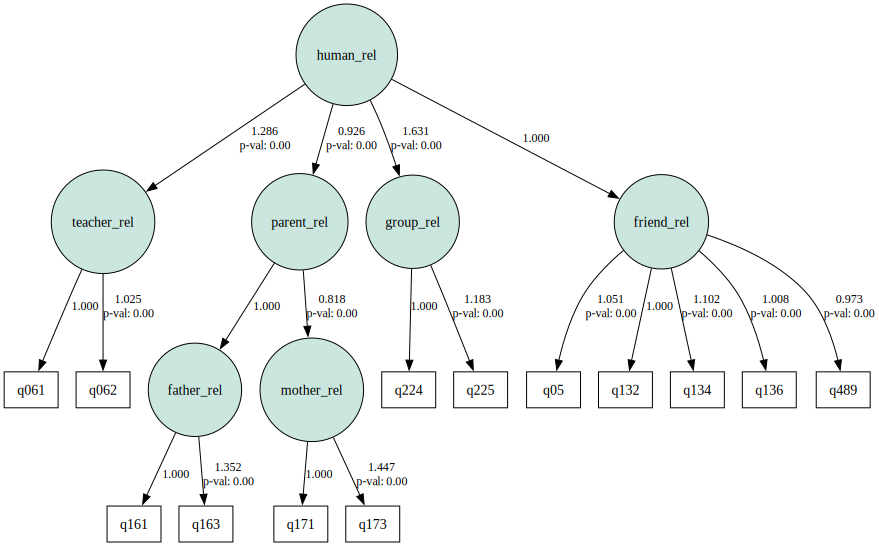

In [127]:
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\human_rel.png')

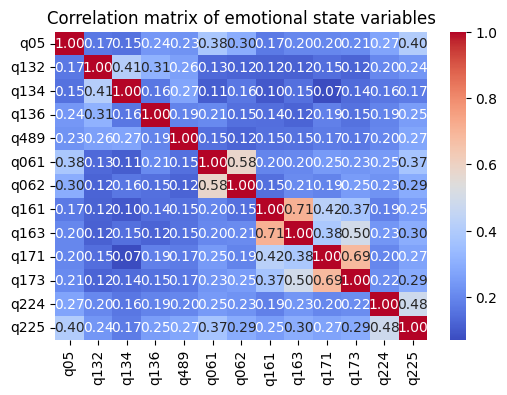

In [128]:
# 문제된 변수만 추출
rel_corr_df = df_rel[observed_vars].copy()

# 상관행렬 계산
corr_matrix = rel_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [129]:
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]
df['teacher_rel'] = factor_scores["teacher_rel"]
df['friend_rel'] = factor_scores["friend_rel"]
df['parent_rel'] = factor_scores["parent_rel"]
df['group_rel'] = factor_scores["group_rel"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... exposure_violence body_image_experience   support  \
0   아니오   아니오  ...         -0.024783             -0.468777  0.123521   
1     예     예  ...         -0.024538             -0.366024  0.123521   
2     예     예  ...         -0.024783              0.002915  0.004049   
3     예     예  ...         -0.024293              0.313212 -0.142706   
4   아니오     예  ...         -0.024783              0.203523  0.123521   

  time_support financial_support financial_environment crisis_behavior  \
0     0.162600          0.167118    

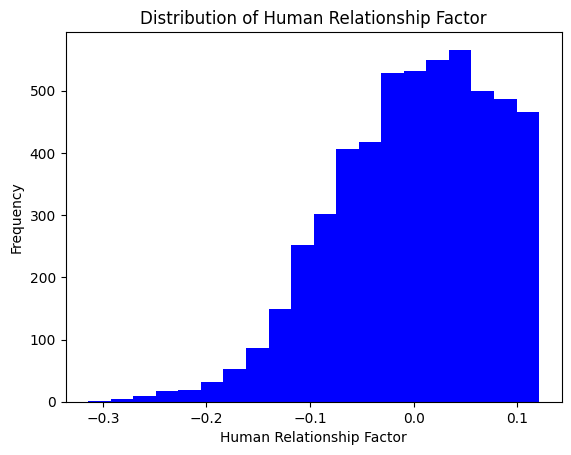

In [33]:
plt.hist(df["human_rel"], bins=20, color='blue')
plt.title("Distribution of Human Relationship Factor")
plt.xlabel("Human Relationship Factor")
plt.ylabel("Frequency")
plt.show()

# 정서적 상태

In [34]:
emo = df[['q221', 'q222', 'q223', 'q226', 'q23', 'q26']]
emo.isnull().sum()

q221    0
q222    0
q223    0
q226    0
q23     0
q26     0
dtype: int64

In [35]:
for i in emo.columns:
    display(emo[i].value_counts())

q221
매우 그렇다       1998
조금 그렇다       1508
보통이다         1225
별로 그렇지 않다     506
전혀 그렇지 않다     139
Name: count, dtype: int64

q222
매우 그렇다       1815
조금 그렇다       1546
보통이다         1256
별로 그렇지 않다     507
전혀 그렇지 않다     252
Name: count, dtype: int64

q223
매우 그렇다       1605
조금 그렇다       1464
보통이다         1454
별로 그렇지 않다     610
전혀 그렇지 않다     243
Name: count, dtype: int64

q226
전혀 그렇지 않다    1575
별로 그렇지 않다    1463
보통이다         1150
조금 그렇다        798
매우 그렇다        390
Name: count, dtype: int64

q23
대체로 행복한 편이다       3106
매우 행복하다           1063
별로 행복하지 않은 편이다     708
모르겠다               388
전혀 행복하지 않다         111
Name: count, dtype: int64

q26
보통이다       1865
약간 행복하다    1450
매우 행복하다    1340
약간 불행하다     575
매우 불행하다     146
Name: count, dtype: int64

In [36]:
emo = encoding(emo, ['q221', 'q222', 'q223'], category5_map)
emo = encoding(emo, ['q226'], reverse_category5_map)
emo = encoding(emo, ['q23'], happy_map)
emo = encoding(emo, ['q26'], how_happy_map)

In [37]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q221    5376 non-null   category
 1   q222    5376 non-null   category
 2   q223    5376 non-null   category
 3   q226    5376 non-null   category
 4   q23     5376 non-null   category
 5   q26     5376 non-null   category
dtypes: category(6)
memory usage: 32.9 KB


In [38]:
scaler = MinMaxScaler()
emo = pd.DataFrame(scaler.fit_transform(emo), columns=emo.columns)

In [39]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   q221    5376 non-null   float64
 1   q222    5376 non-null   float64
 2   q223    5376 non-null   float64
 3   q226    5376 non-null   float64
 4   q23     5376 non-null   float64
 5   q26     5376 non-null   float64
dtypes: float64(6)
memory usage: 252.1 KB


In [40]:
model_desc = """
emotional_state =~ q221 + q223 + q226 + q23
"""

In [41]:
emo['wt'] = df['wt']
observed_vars = ['q221', 'q223', 'q226', 'q23']
w_cov_df = calculate_covariance(emo, observed_vars)

적합도 지표:
                      Value
DoF               2.000000
DoF Baseline      6.000000
chi2             22.569467
chi2 p-value      0.000013
chi2 Baseline  5595.678654
CFI               0.996320
GFI               0.995967
AGFI              0.987900
NFI               0.995967
TLI               0.988960
RMSEA             0.043743
AIC              15.991604
BIC              68.709203
LogLik            0.004198 


모수 추정치:
               lval  op             rval  Estimate  Std. Err    z-value p-value
0             q221   ~  emotional_state  1.000000         -          -       -
1             q223   ~  emotional_state  1.542916  0.039907  38.662765     0.0
2             q226   ~  emotional_state  0.957764  0.032574  29.403152     0.0
3              q23   ~  emotional_state  1.093968  0.028468  38.427411     0.0
4  emotional_state  ~~  emotional_state  0.025571  0.001206  21.202969     0.0
5             q221  ~~             q221  0.049857   0.00109  45.754518     0.0
6             q223  ~

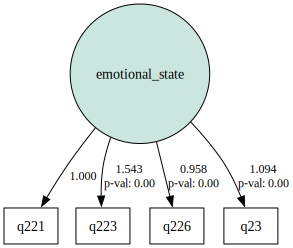

In [42]:
vif_df = compute_vif(emo, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, emo, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\emotional_state.png')

In [43]:
factor_scores = model.predict_factors(emo)

df["emotional_state"] = factor_scores["emotional_state"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...        wt academic_pressure academic_stress exam_anxiety  \
0   아니오   아니오  ...  0.250048         -0.374990       -0.473441     0.002692   
1     예     예  ...  0.250048         -0.102685       -0.232045    -0.143317   
2     예     예  ...  0.250048         -0.345626       -0.485064    -0.066025   
3     예     예  ...  0.244036          0.020866        0.068232     0.058778   
4   아니오     예  ...  0.244036         -0.289557       -0.158075     0.293986   

  human_rel teacher_rel friend_rel parent_rel group_rel emotional_st

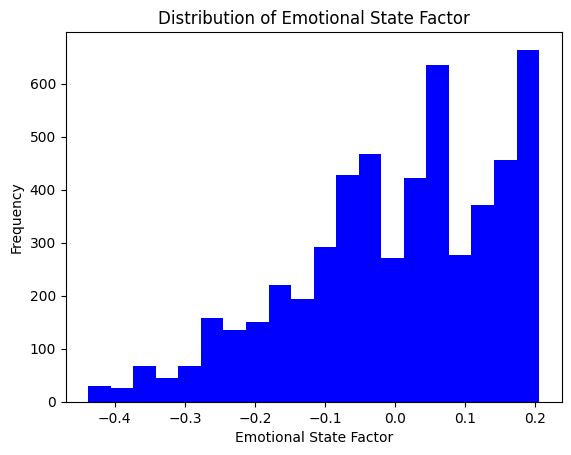

In [44]:
plt.hist(df["emotional_state"], bins=20, color='blue')
plt.title("Distribution of Emotional State Factor")
plt.xlabel("Emotional State Factor")
plt.ylabel("Frequency")
plt.show()

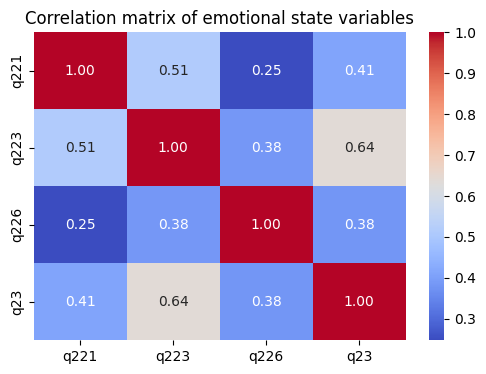

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 문제된 변수만 추출
emo_vars = ['q221', 'q223', 'q226', 'q23']
emo_corr_df = emo[emo_vars].copy()

# 상관행렬 계산
corr_matrix = emo_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [46]:
print(df[df['q35'] == '있다'])

           id sex  birthy birthm                 area         size school  \
8     20009.0  남성  2003.0     7월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
25    20026.0  남성  2003.0     8월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
73    20074.0  여성  2008.0     5월      충청권(대전, 충남, 충북)         중소도시    중학생   
94    20095.0  여성  2003.0     3월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
95    20096.0  남성  2008.0     4월      충청권(대전, 충남, 충북)         중소도시    중학생   
...       ...  ..     ...    ...                  ...          ...    ...   
5196  25197.0  남성  2006.0     8월      호남권(광주, 전남, 전북)         중소도시    중학생   
5218  25219.0  남성  2007.0     6월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5225  25226.0  남성  2007.0     2월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5245  25246.0  여성  2007.0    11월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5343  25344.0  남성  2003.0     5월      수도권(서울, 경기, 인천)          대도시   고등학생   

     grade home1 home2  ...        wt academic_pressure academic_stress  \


# 학교 폭력 노출도

In [47]:
df_vio = df[['q33', 'q35', 'q351', 'q352']]

In [48]:
display(df_vio['q33'].value_counts())
display(df_vio['q35'].value_counts())
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q33
별로 심각하지 않다    1670
전혀 심각하지 않다    1646
보통이다          1313
약간 심각한 편이다     458
매우 심각하다        289
Name: count, dtype: int64

q35
없다    5207
있다     169
Name: count, dtype: int64

q351
1.0       98
2.0       24
3.0       14
5.0        9
4.0        8
모름/무응답     7
10.0       3
20.0       2
6.0        2
9.0        1
50.0       1
Name: count, dtype: int64

q352
1.0       69
2.0       31
3.0       18
4.0       14
10.0       9
모름/무응답     8
5.0        7
6.0        4
8.0        3
20.0       2
9.0        1
7.0        1
17.0       1
16.0       1
Name: count, dtype: int64

In [49]:
df_vio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q33     5376 non-null   category
 1   q35     5376 non-null   category
 2   q351    169 non-null    category
 3   q352    169 non-null    category
dtypes: category(4)
memory usage: 22.5 KB


In [50]:
df_vio = encoding(df_vio, ['q33'], how_serious_map)
df_vio = encoding(df_vio, ['q35'], is_or_not_map)
df_vio['q351'] = df_vio['q351'].replace({'모름/무응답' : 2})
df_vio['q351'] = df_vio['q351'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio['q352'] = df_vio['q352'].replace({'모름/무응답' : 2})
df_vio['q352'] = df_vio['q352'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio = null0(df_vio)
df_vio

,q33,q35,q351,q352
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,0,0,0.0,0.0
3,2,0,0.0,0.0
4,0,0,0.0,0.0
...,...,...,...,...
5371,0,0,0.0,0.0
5372,1,0,0.0,0.0
5373,3,0,0.0,0.0
5374,0,0,0.0,0.0


In [51]:
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q351
0.0    5207
1.0      98
2.0      71
Name: count, dtype: int64

q352
0.0    5207
2.0     100
1.0      69
Name: count, dtype: int64

In [52]:
model_desc = """
exposure_violence =~ q33 + q35 + q351 + q352
"""

In [53]:

df_vio['wt'] = df['wt']
observed_vars = ['q33', 'q35', 'q351', 'q352']
w_cov_df = calculate_covariance(df_vio, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_vio, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                       Value
DoF                2.000000
DoF Baseline       6.000000
chi2              11.230035
chi2 p-value       0.003643
chi2 Baseline  25555.212192
CFI                0.999639
GFI                0.999561
AGFI               0.998682
NFI                0.999561
TLI                0.998916
RMSEA              0.029302
AIC               15.995822
BIC               68.713421
LogLik             0.002089 


모수 추정치:
                 lval  op               rval  Estimate  Std. Err    z-value  \
0                q33   ~  exposure_violence  1.000000         -          -   
1                q35   ~  exposure_violence  1.225419  0.143113   8.562601   
2               q351   ~  exposure_violence  1.868277   0.21824   8.560674   
3               q352   ~  exposure_violence  2.026795  0.236724   8.561832   
4  exposure_violence  ~~  exposure_violence  0.017143  0.004017   4.268067   
5                q33  ~~                q33  1.234066  0.023808   51.83299   
6            

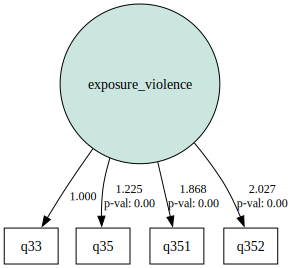

In [54]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\school_violence.png')


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... academic_pressure academic_stress exam_anxiety human_rel  \
0   아니오   아니오  ...         -0.374990       -0.473441     0.002692 -0.054012   
1     예     예  ...         -0.102685       -0.232045    -0.143317  0.038859   
2     예     예  ...         -0.345626       -0.485064    -0.066025  0.041169   
3     예     예  ...          0.020866        0.068232     0.058778 -0.039441   
4   아니오     예  ...         -0.289557       -0.158075     0.293986  0.077037   

  teacher_rel friend_rel parent_rel group_rel emotional_state  \
0  

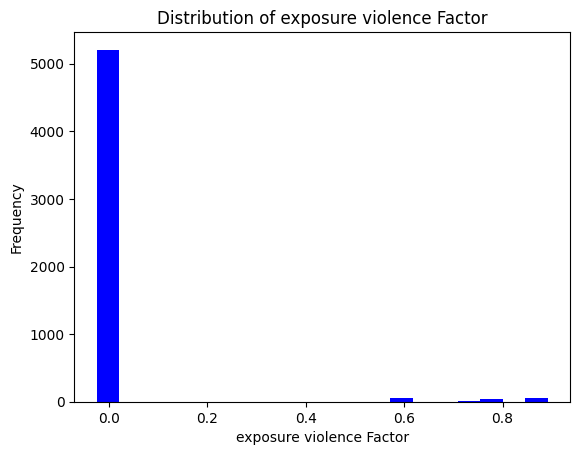

In [55]:
factor_scores = model.predict_factors(df_vio)

df["exposure_violence"] = factor_scores["exposure_violence"]

print(df.head())
plt.hist(df["exposure_violence"], bins=20, color='blue')
plt.title("Distribution of exposure violence Factor")
plt.xlabel("exposure violence Factor")
plt.ylabel("Frequency")
plt.show()

In [56]:
df['exposure_violence'].value_counts()

exposure_violence
-0.024538    1636
-0.024783    1625
-0.024293    1260
-0.024048     418
-0.023803     268
 0.607752      20
 0.891943      18
 0.765818      16
 0.607507      15
 0.891698      14
 0.892188      12
 0.607997       9
 0.607262       9
 0.765573       9
 0.766063       9
 0.766308       8
 0.891453       6
 0.891208       6
 0.733142       4
 0.733878       4
 0.733387       4
 0.733633       3
 0.765328       2
 0.608242       1
Name: count, dtype: int64

# 외모 및 신체 이미지

In [57]:
body = df[['q42', 'q43', 'q4812', 'q4813', 'q4814', 'q4815']]
body.isnull().sum()

q42      0
q43      0
q4812    0
q4813    0
q4814    0
q4815    0
dtype: int64

In [58]:
for i in body.columns:
    display(body[i].value_counts())

q42
160.0    361
170.0    315
165.0    263
158.0    246
163.0    243
        ... 
185.4      1
193.0      1
192.0      1
194.0      1
200.0      1
Name: count, Length: 241, dtype: int64

q43
60.0     269
50.0     266
55.0     238
53.0     195
70.0     191
        ... 
150.0      1
161.0      1
165.0      1
190.0      1
200.0      1
Name: count, Length: 229, dtype: int64

q4812
전혀 그렇지 않다    1959
조금 그렇다       1018
보통이다          952
별로 그렇지 않다     945
매우 그렇다        502
Name: count, dtype: int64

q4813
전혀 그렇지 않다    2346
별로 그렇지 않다    1112
보통이다          885
조금 그렇다        742
매우 그렇다        291
Name: count, dtype: int64

q4814
전혀 그렇지 않다    1984
별로 그렇지 않다    1168
보통이다         1064
조금 그렇다        825
매우 그렇다        335
Name: count, dtype: int64

q4815
전혀 그렇지 않다    2532
별로 그렇지 않다    1156
보통이다          838
조금 그렇다        597
매우 그렇다        253
Name: count, dtype: int64

In [59]:
body = encoding(body, ['q4812', 'q4813', 'q4814', 'q4815'], category5_map)
body = calculate_bmi(body, 'q42', 'q43')
body['obesity'] = body['bmi'].apply(lambda x: (
    0 if x < 18.5 else
    1 if x < 23 else
    2 if x < 25 else
    3 if x < 30 else
    4 if x < 35 else
    5
))

body['obesity'] = body['obesity'].astype('category')

In [60]:
scaler = MinMaxScaler()
body[['q42', 'q43']] = scaler.fit_transform(body[['q42', 'q43']])

In [61]:
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   q42      5317 non-null   float64 
 1   q43      5283 non-null   float64 
 2   q4812    5376 non-null   category
 3   q4813    5376 non-null   category
 4   q4814    5376 non-null   category
 5   q4815    5376 non-null   category
 6   bmi      5283 non-null   float64 
 7   obesity  5376 non-null   category
dtypes: category(5), float64(3)
memory usage: 153.4 KB


In [62]:
body.head(3)

,q42,q43,q4812,q4813,q4814,q4815,bmi,obesity
0,0.58,0.277778,0,0,0,0,28.04,3
1,0.60,0.194444,2,0,0,0,21.48,1
2,0.66,0.188889,2,2,1,1,19.60,1


In [63]:
model_desc = '''
body_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_image_experience =~ body_stress + body_info

q4812 ~~ q4813
q4812 ~~ obesity
'''

In [64]:
body['wt'] = df['wt']
observed_vars = ['q4812', 'q4813', 'q4814','q4815', 'obesity', 'q42', 'q43']
w_cov_df = calculate_covariance(body, observed_vars)
vif_df = compute_vif(body, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, body, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                      Value
DoF               1.000000
DoF Baseline     10.000000
chi2             19.450122
chi2 p-value      0.000010
chi2 Baseline  6457.187876
CFI               0.997138
GFI               0.996988
AGFI              0.969878
NFI               0.996988
TLI               0.971383
RMSEA             0.058588
AIC              27.992764
BIC             120.248562
LogLik            0.003618 


모수 추정치:
                      lval  op                   rval  Estimate  Std. Err  \
0             body_stress   ~  body_image_experience  1.000000         -   
1               body_info   ~  body_image_experience  0.153791  0.037631   
2                   q4812   ~            body_stress  1.000000         -   
3                   q4813   ~            body_stress  0.724073  0.021249   
4                   q4814   ~            body_stress  1.149342  0.027202   
5                   q4815   ~            body_stress  0.945319  0.022608   
6                 obesity   ~             

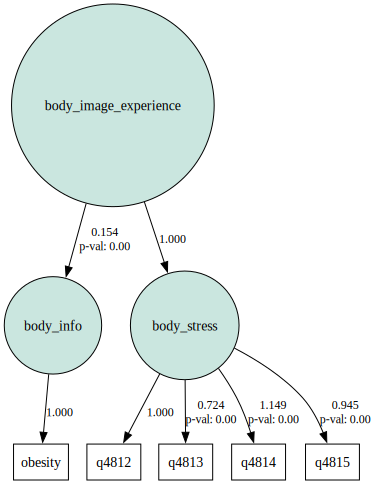

In [65]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\body_image_experience.png')

In [66]:
factor_scores = model.predict_factors(body)

df["body_image_experience"] = factor_scores["body_image_experience"]

print(df.head())


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... academic_stress exam_anxiety human_rel teacher_rel  \
0   아니오   아니오  ...       -0.473441     0.002692 -0.054012   -0.120981   
1     예     예  ...       -0.232045    -0.143317  0.038859   -0.033750   
2     예     예  ...       -0.485064    -0.066025  0.041169    0.224625   
3     예     예  ...        0.068232     0.058778 -0.039441   -0.022833   
4   아니오     예  ...       -0.158075     0.293986  0.077037    0.240616   

  friend_rel parent_rel group_rel emotional_state exposure_violence  \
0   0.091261   0.202138 -0.165288

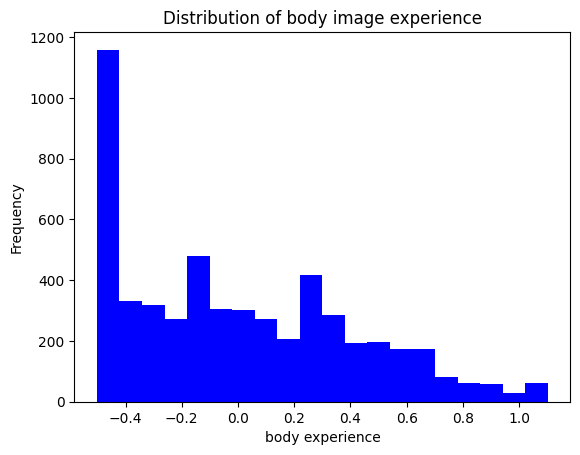

body_image_experience
-0.490741    554
-0.501723    238
-0.103438    145
 0.283865    107
-0.468777    104
            ... 
 0.116204      1
 0.619568      1
 0.145550      1
 0.448571      1
 0.801771      1
Name: count, Length: 1300, dtype: int64

In [67]:
plt.hist(df["body_image_experience"], bins=20, color='blue')
plt.title("Distribution of body image experience")
plt.xlabel("body experience")
plt.ylabel("Frequency")
plt.show()
df['body_image_experience'].value_counts()

# 부모의 경제적 지원

In [68]:
# 재정적 지원
financial_support = ['q38', 'q4816', 'q4817']
time_support = ['q162', 'q172']
support = pd.concat([df[financial_support], df[time_support]], axis=1)
support['need_money'] = df['q27'].apply(lambda x: 0 if x == '돈' else 1)
support.head(3)

,q38,q4816,q4817,q162,q172,need_money
0,중의 하,전혀 그렇지 않다,전혀 그렇지 않다,매우 그렇다,매우 그렇다,1
1,중의 하,전혀 그렇지 않다,전혀 그렇지 않다,매우 그렇다,매우 그렇다,1
2,중의 상,별로 그렇지 않다,별로 그렇지 않다,매우 그렇다,보통이다,1


In [69]:
for i in support.columns:
    display(support[i].value_counts())

q38
중의 상    2655
중의 하    1524
상의 하     623
상의 상     283
하의 상     230
하의 하      61
Name: count, dtype: int64

q4816
전혀 그렇지 않다    2779
별로 그렇지 않다    1193
보통이다          715
조금 그렇다        460
매우 그렇다        210
해당사항 없음        19
Name: count, dtype: int64

q4817
전혀 그렇지 않다    2549
별로 그렇지 않다    1263
보통이다          863
조금 그렇다        492
매우 그렇다        209
Name: count, dtype: int64

q162
매우 그렇다       2244
조금 그렇다       1190
보통이다         1130
별로 그렇지 않다     425
해당사항 없음       215
전혀 그렇지 않다     172
Name: count, dtype: int64

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

need_money
1    3752
0    1624
Name: count, dtype: int64

In [70]:
support = encoding(support, ['q38'], how_high_map)
support = not_applicable(support, ['q4816', 'q162','q172'])
support = encoding(support, ['q4816', 'q4817'], reverse_category5_map)
support = encoding(support, ['q162', 'q172'], category5_map)
support['need_money'].astype('category')
support.head(3)

,q38,q4816,q4817,q162,q172,need_money
0,1,4,4,4,4,1
1,1,4,4,4,4,1
2,1,3,3,4,2,1


In [71]:
scaler = MinMaxScaler()
support[['q4816', 'q4817', 'q162', 'q172']] = scaler.fit_transform(support[['q4816', 'q4817', 'q162', 'q172']])

In [72]:
support['q38'] = pd.Categorical(support['q38'], categories=[0, 1, 2], ordered=True)

In [73]:
support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   q38         5376 non-null   category
 1   q4816       5376 non-null   float64 
 2   q4817       5376 non-null   float64 
 3   q162        5376 non-null   float64 
 4   q172        5376 non-null   float64 
 5   need_money  5376 non-null   int64   
dtypes: category(1), float64(4), int64(1)
memory usage: 215.5 KB


In [74]:
model_desc = """
    financial_support =~ q4816 + q4817
    financial_environment =~ q38 + need_money
    time_support =~ q162 + q172
    support =~ financial_support + time_support
    financial_support ~~ financial_environment
    q4816 ~~ q4817
    financial_support ~~ financial_environment
"""


In [75]:
support['wt'] = df['wt']
observed_vars = ['q38', 'q4816', 'q4817', 'q162', 'q172', 'need_money']
w_cov_df = calculate_covariance(support, observed_vars)

적합도 지표:
                       Value
DoF            4.000000e+00
DoF Baseline   1.500000e+01
chi2           4.637538e+01
chi2 p-value   2.057351e-09
chi2 Baseline  6.668183e+03
CFI            9.936308e-01
GFI            9.930453e-01
AGFI           9.739198e-01
NFI            9.930453e-01
TLI            9.761155e-01
RMSEA          4.439536e-02
AIC            3.398275e+01
BIC            1.460076e+02
LogLik         8.626373e-03 


모수 추정치:
                      lval  op                   rval  Estimate  Std. Err  \
0       financial_support   ~                support  1.000000         -   
1            time_support   ~                support  0.494331  0.000442   
2                   q4816   ~      financial_support  1.000000         -   
3                   q4817   ~      financial_support  1.025746  0.034338   
4                     q38   ~  financial_environment  1.000000         -   
5              need_money   ~  financial_environment  0.997035   0.07612   
6                    q162  

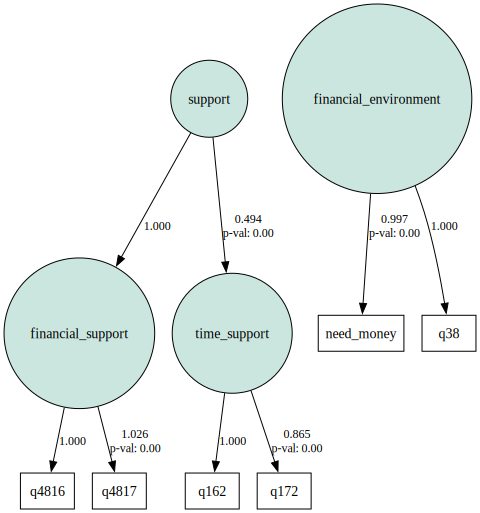

In [76]:
model = Model(model_desc)
model = fit_sem_model(model, support, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\support.png')

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... friend_rel parent_rel group_rel emotional_state  \
0   아니오   아니오  ...   0.091261   0.202138 -0.165288       -0.167932   
1     예     예  ...   0.136423   0.200562  0.057882        0.058954   
2     예     예  ...  -0.023282  -0.048613  0.086494       -0.085814   
3     예     예  ...  -0.250260  -0.069551 -0.044748        0.044651   
4   아니오     예  ...   0.063430   0.199914  0.133507        0.205492   

  exposure_violence body_image_experience   support time_support  \
0         -0.024783             -0.468777  0.123521   

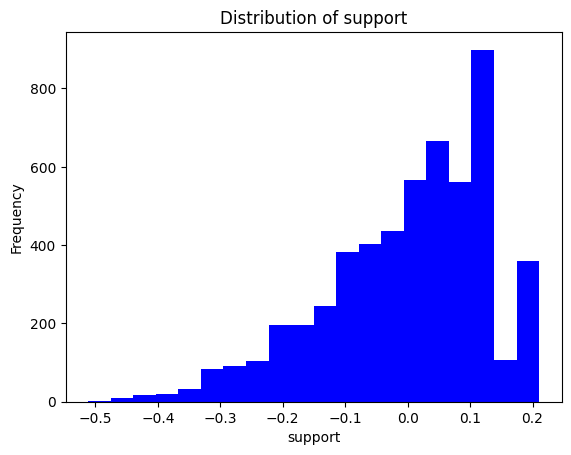

support
 0.123521    591
 0.210491    240
 0.033711    164
 0.110215    140
 0.040483    130
            ... 
-0.119270      1
 0.054670      1
-0.295475      1
-0.096898      1
-0.139876      1
Name: count, Length: 939, dtype: int64

In [77]:
factor_scores = model.predict_factors(support)

df["support"] = factor_scores["support"]
df['time_support'] = factor_scores["time_support"]
df['financial_support'] = factor_scores["financial_support"]
df['financial_environment'] = factor_scores["financial_environment"]
print(df.head())

plt.hist(df["support"], bins=20, color='blue')
plt.title("Distribution of support")
plt.xlabel("support")
plt.ylabel("Frequency")
plt.show()
df['support'].value_counts()

# 위험행동

In [78]:
df['q302'].value_counts()

q302
없다    1611
있다     316
Name: count, dtype: int64

In [79]:
crisis = df[['q287', 'q288', 'q289', 'q2810','q29', 'q31']]
crisis.isnull().sum()

q287     0
q288     0
q289     0
q2810    0
q29      0
q31      0
dtype: int64

In [80]:
crisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q287    5376 non-null   category
 1   q288    5376 non-null   category
 2   q289    5376 non-null   category
 3   q2810   5376 non-null   category
 4   q29     5376 non-null   category
 5   q31     5376 non-null   category
dtypes: category(6)
memory usage: 32.5 KB


In [81]:
crisis = encoding(crisis, ['q287', 'q288', 'q289', 'q2810'], yes_or_no_map)
crisis = encoding(crisis, ['q29', 'q31'], how_much_is_map)
# crisis = encoding(crisis, ['q302'], is_or_not_map)

crisis = null0(crisis)

In [82]:
model_desc = """
    substance =~  q287 + q288 + q289
    impulse =~ q29 + q31
    crisis_behavior =~ substance + q2810 + impulse
"""

In [83]:
crisis['wt'] = df['wt']
observed_vars = ['q287', 'q288', 'q289', 'q2810', 'q29', 'q31']
w_cov_df = calculate_covariance(crisis, observed_vars)

적합도 지표:
                      Value
DoF               7.000000
DoF Baseline     15.000000
chi2            105.541518
chi2 p-value      0.000000
chi2 Baseline  3487.132623
CFI               0.971619
GFI               0.969734
AGFI              0.935144
NFI               0.969734
TLI               0.939184
RMSEA             0.051177
AIC              27.960736
BIC             120.216534
LogLik            0.019632 


모수 추정치:
                lval  op             rval  Estimate  Std. Err    z-value  \
0         substance   ~  crisis_behavior  1.000000         -          -   
1           impulse   ~  crisis_behavior  4.635411  0.596668   7.768834   
2              q287   ~        substance  1.000000         -          -   
3              q288   ~        substance  1.782693  0.122343  14.571281   
4              q289   ~        substance  0.511073  0.035059  14.577701   
5               q29   ~          impulse  1.000000         -          -   
6               q31   ~          impulse  0.71632

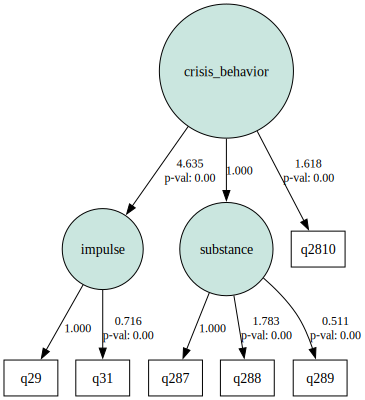

In [84]:
model = Model(model_desc)
model = fit_sem_model(model, crisis, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\crisis.png')

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... emotional_state exposure_violence body_image_experience  \
0   아니오   아니오  ...       -0.167932         -0.024783             -0.468777   
1     예     예  ...        0.058954         -0.024538             -0.366024   
2     예     예  ...       -0.085814         -0.024783              0.002915   
3     예     예  ...        0.044651         -0.024293              0.313212   
4   아니오     예  ...        0.205492         -0.024783              0.203523   

    support time_support financial_support financial_environment  \
0  0.1

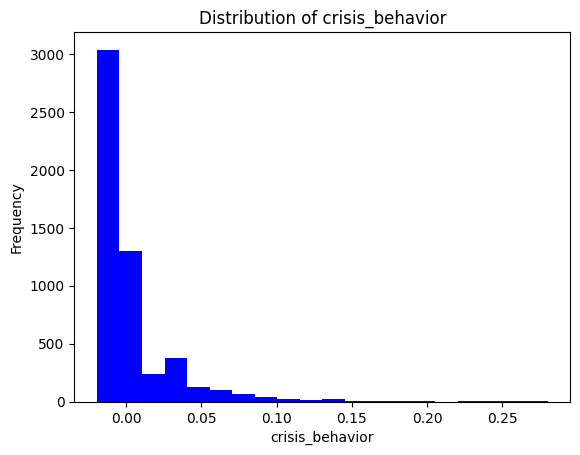

crisis_behavior
-0.019439    2599
 0.003816     482
-0.000076     473
-0.015546     352
 0.027071     170
             ... 
 0.168520       1
 0.095805       1
 0.186648       1
 0.094659       1
 0.164954       1
Name: count, Length: 83, dtype: int64

In [85]:
factor_scores = model.predict_factors(crisis)

df["crisis_behavior"] = factor_scores["crisis_behavior"]
df['impulse'] = factor_scores["impulse"]
df['substance'] = factor_scores["substance"]

print(df.head())

plt.hist(df["crisis_behavior"], bins=20, color='blue')
plt.title("Distribution of crisis_behavior")
plt.xlabel("crisis_behavior")
plt.ylabel("Frequency")
plt.show()
df['crisis_behavior'].value_counts()

# 조절효과 회귀분석 (OLS)

In [86]:
# df = df[df['school'] == '고등학생']
# df.head(3)

### emotional_state ~ academic_pressure + rel

In [87]:
df['interaction'] = df['academic_pressure'] * df['group_rel']

model = smf.ols('emotional_state ~ academic_pressure + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     991.0
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:03:54   Log-Likelihood:                 3878.4
No. Observations:                5376   AIC:                            -7749.
Df Residuals:                    5372   BIC:                            -7722.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8.127e-05      0.00

In [88]:
df['interaction'] = df['academic_pressure'] * df['teacher_rel']

model = smf.ols('emotional_state ~ academic_pressure + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     311.8
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          1.25e-186
Time:                        00:03:54   Log-Likelihood:                 3125.9
No. Observations:                5376   AIC:                            -6244.
Df Residuals:                    5372   BIC:                            -6217.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0005      0.00

In [89]:
df["interaction"] = df["academic_pressure"] * df["parent_rel"]

model = smf.ols("emotional_state ~ academic_pressure + parent_rel + interaction", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     526.8
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          4.07e-300
Time:                        00:03:54   Log-Likelihood:                 3387.6
No. Observations:                5376   AIC:                            -6767.
Df Residuals:                    5372   BIC:                            -6741.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.964e-05      0.00

In [90]:
df['interaction'] = df['academic_pressure'] * df['friend_rel']

model = smf.ols('emotional_state ~ academic_pressure + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     491.9
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          2.13e-282
Time:                        00:03:54   Log-Likelihood:                 3346.8
No. Observations:                5376   AIC:                            -6686.
Df Residuals:                    5372   BIC:                            -6659.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           2.08e-05      0.00

### impulse ~ violence + rel

In [91]:
df['interaction'] = df['exposure_violence'] * df['group_rel']

model = smf.ols('impulse ~ exposure_violence + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     133.9
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.24e-83
Time:                        00:03:54   Log-Likelihood:                -4143.5
No. Observations:                5376   AIC:                             8295.
Df Residuals:                    5372   BIC:                             8321.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0006      0.00

In [92]:
df['interaction'] = df['exposure_violence'] * df['teacher_rel']

model = smf.ols('impulse ~ exposure_violence + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     74.36
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           4.06e-47
Time:                        00:03:54   Log-Likelihood:                -4227.9
No. Observations:                5376   AIC:                             8464.
Df Residuals:                    5372   BIC:                             8490.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0001      0.00

In [93]:
df['interaction'] = df['exposure_violence'] * df['parent_rel']

model = smf.ols('impulse ~ exposure_violence + parent_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     332.0
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          8.80e-198
Time:                        00:03:54   Log-Likelihood:                -3880.0
No. Observations:                5376   AIC:                             7768.
Df Residuals:                    5372   BIC:                             7794.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0003      0.00

In [94]:
df['interaction'] = df['exposure_violence'] * df['friend_rel']

model = smf.ols('impulse ~ exposure_violence + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     115.3
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           2.32e-72
Time:                        00:03:54   Log-Likelihood:                -4169.5
No. Observations:                5376   AIC:                             8347.
Df Residuals:                    5372   BIC:                             8373.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0003      0.00

### impulse ~ emotional_state + rel

In [95]:
df['interaction'] = df['emotional_state'] * df['group_rel']

model = smf.ols('impulse ~ emotional_state + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     426.7
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          1.29e-248
Time:                        00:03:54   Log-Likelihood:                -3762.8
No. Observations:                5376   AIC:                             7534.
Df Residuals:                    5372   BIC:                             7560.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0185      0.008     

In [96]:
df['interaction'] = df['emotional_state'] * df['teacher_rel']

model = smf.ols('impulse ~ emotional_state + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     419.7
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          5.89e-245
Time:                        00:03:54   Log-Likelihood:                -3771.2
No. Observations:                5376   AIC:                             7550.
Df Residuals:                    5372   BIC:                             7577.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0081      0.007     

In [97]:
df['interaction'] = df['emotional_state'] * df['parent_rel']

model = smf.ols('impulse ~ emotional_state + parent_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     546.3
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          7.46e-310
Time:                        00:03:54   Log-Likelihood:                -3621.6
No. Observations:                5376   AIC:                             7251.
Df Residuals:                    5372   BIC:                             7278.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0178      0.007     

In [98]:
df['interaction'] = df['emotional_state'] * df['friend_rel']

model = smf.ols('impulse ~ emotional_state + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     423.2
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          8.43e-247
Time:                        00:03:54   Log-Likelihood:                -3767.0
No. Observations:                5376   AIC:                             7542.
Df Residuals:                    5372   BIC:                             7568.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0105      0.007     

In [99]:
df['interaction'] = df['emotional_state'] * df['human_rel']

model = smf.ols('impulse ~ emotional_state + human_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     427.6
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          4.03e-249
Time:                        00:03:54   Log-Likelihood:                -3761.6
No. Observations:                5376   AIC:                             7531.
Df Residuals:                    5372   BIC:                             7558.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0202      0.008     

### Y ~ X + support

In [100]:
df['interaction'] = df['academic_pressure'] * df['support']

model = smf.ols('emotional_state ~ academic_pressure + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     362.9
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          1.26e-214
Time:                        00:03:54   Log-Likelihood:                 3190.5
No. Observations:                5376   AIC:                            -6373.
Df Residuals:                    5372   BIC:                            -6347.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0002      0.00

In [101]:
df['interaction'] = df['academic_pressure'] * df['support']

model = smf.ols('impulse ~ academic_pressure + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     244.8
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          6.57e-149
Time:                        00:03:54   Log-Likelihood:                -3992.8
No. Observations:                5376   AIC:                             7994.
Df Residuals:                    5372   BIC:                             8020.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           4.58e-05      0.00

In [102]:
df['interaction'] = df['academic_pressure'] * df['support']

model = smf.ols('parent_rel ~ academic_pressure + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             parent_rel   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     492.3
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          1.32e-282
Time:                        00:03:54   Log-Likelihood:                 2147.6
No. Observations:                5376   AIC:                            -4287.
Df Residuals:                    5372   BIC:                            -4261.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0003      0.00

In [103]:
df['interaction'] = df['emotional_state'] * df['support']

model = smf.ols('parent_rel ~ emotional_state + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             parent_rel   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     809.8
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:03:54   Log-Likelihood:                 2497.7
No. Observations:                5376   AIC:                            -4987.
Df Residuals:                    5372   BIC:                            -4961.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0003      0.002     

In [104]:
df['interaction'] = df['emotional_state'] * df['support']

model = smf.ols('impulse ~ emotional_state + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     522.1
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          9.96e-298
Time:                        00:03:54   Log-Likelihood:                -3649.6
No. Observations:                5376   AIC:                             7307.
Df Residuals:                    5372   BIC:                             7333.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0116      0.007     

In [105]:
df['interaction'] = df['emotional_state'] * df['support']

model = smf.ols('crisis_behavior ~ emotional_state + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        crisis_behavior   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     183.2
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          4.09e-113
Time:                        00:03:54   Log-Likelihood:                 11063.
No. Observations:                5376   AIC:                        -2.212e+04
Df Residuals:                    5372   BIC:                        -2.209e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0004      0.000     

In [106]:
df['interaction'] = df['human_rel'] * df['support']

model = smf.ols('academic_pressure ~ human_rel + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      academic_pressure   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     14.34
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           2.63e-09
Time:                        00:03:55   Log-Likelihood:                 3014.1
No. Observations:                5376   AIC:                            -6020.
Df Residuals:                    5372   BIC:                            -5994.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0021      0.002      1.057      

In [107]:
df['interaction'] = df['financial_environment'] * df['support']

model = smf.ols('emotional_state ~ financial_environment + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     395.9
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          2.40e-232
Time:                        00:03:55   Log-Likelihood:                 3231.3
No. Observations:                5376   AIC:                            -6455.
Df Residuals:                    5372   BIC:                            -6428.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.00

In [108]:
df['interaction'] = df['academic_stress'] * df['support']

model = smf.ols('crisis_behavior ~ academic_stress + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        crisis_behavior   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     109.8
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           5.51e-69
Time:                        00:03:55   Log-Likelihood:                 10961.
No. Observations:                5376   AIC:                        -2.191e+04
Df Residuals:                    5372   BIC:                        -2.189e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0002      0.000     

# 종합

In [109]:
everything = pd.concat([df_edu, df_rel, emo, body, df_vio, crisis, support], axis=1)

In [110]:
everything = everything.loc[:, ~everything.columns.duplicated()]

In [111]:
everything.head(3)

,q071,q072,q073,q074,q485,q486,q487,q488,wt,q05,...,q287,q288,q289,q2810,q29,q31,q38,q4816,q4817,need_money
0,0.000000,0.000000,0.000000,0.666667,0.75,0.50,1.0,0.0,0.250048,1.00,...,0,0,0,0,0,0,1,1.00,1.00,1
1,0.333333,0.333333,0.333333,0.333333,0.25,0.25,0.5,0.5,0.250048,0.75,...,0,0,0,0,0,0,1,1.00,1.00,1
2,0.000000,0.000000,0.000000,0.000000,0.50,0.50,0.5,0.5,0.250048,1.00,...,0,0,0,0,1,0,1,0.75,0.75,1


In [ ]:
model_desc = """
academic_stress =~ q072 + q073
exam_anxiety =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety

friend_rel =~ q132 + q134 + q136 + q489 + q05
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
parent_rel =~ father_rel + mother_rel
group_rel =~ q224 + q225
human_rel =~ friend_rel + teacher_rel + parent_rel + group_rel
father_rel ~~ mother_rel

emotional_state =~ q221 + q223 + q226 + q23

body_image_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_image_experience =~ body_image_stress
body_image_experience ~~ body_info

exposure_violence =~ q35 + q351 + q352

substance =~  q287 + q288 + q289
impulse =~ q29 + q31
crisis_behavior =~ substance + q2810 + impulse

financial_support =~ q4816 + q4817 + need_money
financial_environment =~ q38
support =~ financial_support
financial_support ~~ financial_environment

# [1] 정서 상태(emotional_state)에 영향을 주는 요인들
emotional_state ~ academic_pressure          # 학업 압박이 정서 상태에 영향

emotional_state ~ human_rel                  # 인간 관계 → 정서 안정
emotional_state ~ parent_rel                 # 부모와의 관계 → 정서 상태
emotional_state ~ friend_rel                 # 친구 관계 → 정서 상태

emotional_state ~ body_image_experience      # 신체 이미지 경험 → 정서 상태
emotional_state ~ academic_stress            # 학업 스트레스 → 정서 상태
emotional_state ~ exposure_violence          # 폭력 노출 → 정서 상태
emotional_state ~ support

# [2] 충동성과 위기행동에 영향을 주는 정서 상태
impulse ~ emotional_state                    # 감정 상태 → 충동성
crisis_behavior ~ emotional_state            # 정서 상태 → 위기 행동
substance ~ emotional_state

# [3] 폭력 노출의 영향
impulse ~ exposure_violence                  # 폭력 경험 → 충동성
human_rel ~ exposure_violence                # 폭력 경험 → 인간관계 악화
substance ~ exposure_violence

# [5] 학업 스트레스 관련 경로
academic_pressure ~ human_rel
academic_pressure ~ teacher_rel
academic_pressure ~  parent_rel
academic_pressure ~ support
academic_pressure ~ emotional_state

academic_stress ~ human_rel                  # 좋은 인간 관계 → 학업 스트레스 완충
academic_stress ~ teacher_rel             # 시험 불안 → 학업 압박
academic_stress ~ parent_rel                 # 부모 관계 → 학업 스트레스
academic_stress ~ support
academic_stress ~ emotional_state

exam_anxiety ~ human_rel
exam_anxiety ~ teacher_rel
exam_anxiety ~  parent_rel
exam_anxiety ~ support
exam_anxiety ~ emotional_state

# [6] 인간 관계에 영향을 주는 경로
human_rel ~ academic_pressure                # 학업 압박 → 인간 관계 악화
human_rel ~ substance
human_rel ~ support
parent_rel ~ substance                       # 물질 사용 → 부모 관계 악화
parent_rel ~ academic_stress
parent_rel ~ academic_pressure
parent_rel ~ exam_anxiety
parent_rel ~ financial_environment          # 부모 관계 → 경제 환경
friend_rel ~ exposure_violence
teacher_rel ~ substance
teacher_rel ~ exposure_violence                # 폭력 노출 → 교사 관계 악화
teacher_rel ~ exam_anxiety
teacher_rel ~ academic_pressure

# [7] 충동성과 위기행동
impulse ~ academic_pressure                  # 학업 압박 → 충동성
impulse ~ friend_rel                         # 친구 관계 → 충동 억제
impulse ~ parent_rel
impulse ~ exam_anxiety
impulse ~ exposure_violence                 # 폭력 노출 → 충동성
impulse ~ support
impulse ~ human_rel

substance ~ academic_pressure      
substance ~ friend_rel
substance ~ parent_rel
substance ~ exam_anxiety
substance ~ exposure_violence      
substance ~ support            
substance ~ human_rel

crisis_behavior ~ academic_pressure          # 학업 압박 → 위기 행동
crisis_behavior ~ friend_rel
crisis_behavior ~ parent_rel
crisis_behavior ~ exam_anxiety
crisis_behavior ~ exposure_violence          # 폭력 노출 → 위기 행동
crisis_behavior ~ support                   # 가족 지원 → 위기 행동 완화
crisis_behavior ~ human_rel

# [8] 가족의 지원(support)의 영향
emotional_state ~ support                   # 가족 지원 → 정서 안정
human_rel ~ support                         # 가족 지원 → 인간관계 향상
academic_stress ~ support                   # 가족 지원 → 학업 스트레스 완충
academic_pressure ~ support                 # 가족 지원 → 학업 압박 완충
exam_anxiety ~ support                      # 가족 지원 → 시험 불안 완화
impulse ~ support                           # 가족 지원 → 충동성 억제
crisis_behavior ~ support                   # 가족 지원 → 위기 행동 완화
emotional_state ~ financial_environment     # 경제 환경 → 정서 안정
parent_rel ~ support                        # 부모 관계 → 가족 지원
parent_rel ~ financial_environment          # 부모 관계 → 경제 환경
"""

observed_vars = [
    'q072', 'q073', 'q485', 'q486', 'q487', 'q488', 'q221', 'q223', 'q226', 'q23',
    'q05','q132', 'q134', 'q136', 'q489', 'q061', 'q062', 'q161', 'q163', 'q171', 'q173', 'q224', 'q225',
    'q4812', 'q4813', 'q4814', 'q4815', 'obesity', 'q42', 'q43',
    'q33', 'q35', 'q351', 'q352', 
    'q287', 'q288', 'q289', 'q2810','q29', 'q31',
    'q4816', 'q4817', 'q38', 'need_money', 'q162', 'q172'
                ]
w_cov_df = calculate_covariance(everything, observed_vars)
vif_df = compute_vif(everything, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, everything, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\everything.png')
report(model, 'C:\\git_files\\education_analysis\\happy\\report')

적합도 지표:
                       Value
DoF              653.000000
DoF Baseline     780.000000
chi2            6620.549797
chi2 p-value       0.000000
chi2 Baseline  94349.235590
CFI                0.936223
GFI                0.929829
AGFI               0.916182
NFI                0.929829
TLI                0.923819
RMSEA              0.041234
AIC              331.536998
BIC             1432.016878
LogLik             1.231501 


모수 추정치:
                 lval  op               rval  Estimate  Std. Err    z-value  \
0    academic_stress   ~  academic_pressure  1.000000         -          -   
1       exam_anxiety   ~  academic_pressure  1.433476  0.078192  18.332784   
2         father_rel   ~         parent_rel  1.000000         -          -   
3         mother_rel   ~         parent_rel  0.853858  0.031165   27.39786   
4         friend_rel   ~          human_rel  1.000000         -          -   
..               ...  ..                ...       ...       ...        ...   
183          

In [136]:
# 각 하위 요인별 변수 목록
academic_stress_columns = ['q072', 'q073']
exam_anxiety_columns = ['q485', 'q486', 'q487', 'q488']
friend_rel_columns = ['q132', 'q134', 'q136', 'q489', 'q05']
teacher_rel_columns = ['q061', 'q062']
father_rel_columns = ['q161', 'q163']
mother_rel_columns = ['q171', 'q173']
parent_rel_columns = ['q161', 'q163', 'q171', 'q173']
group_rel_columns = ['q224', 'q225']
emotional_state_columns = ['q221', 'q223', 'q226', 'q23']
body_image_stress_columns = ['q4812', 'q4813', 'q4814', 'q4815']
exposure_violence_columns = ['q35', 'q351', 'q352']
substance_columns = ['q287', 'q288', 'q289']
impulse_columns = ['q29', 'q31']
financial_support_columns = ['q4816', 'q4817', 'need_money']

for col in academic_stress_columns + exam_anxiety_columns + friend_rel_columns + teacher_rel_columns + \
        father_rel_columns + mother_rel_columns + parent_rel_columns + group_rel_columns + \
        emotional_state_columns + body_image_stress_columns + \
        exposure_violence_columns + substance_columns + impulse_columns + \
        financial_support_columns:
    # 각 열을 수치형으로 변환
    everything[col] = pd.to_numeric(everything[col], errors='coerce')


# 각 하위 요인별 Cronbach's α 계산 함수
def calculate_cronbach_alpha(columns):
    data = everything[columns]
    return pg.cronbach_alpha(data=data)[0]

# 각 하위 요인별 Cronbach's α 계산
cronbach_results = {}

# 각 하위 요인에 대해 Cronbach's α 계산
cronbach_results['academic_stress'] = calculate_cronbach_alpha(academic_stress_columns)
cronbach_results['exam_anxiety'] = calculate_cronbach_alpha(exam_anxiety_columns)
cronbach_results['friend_rel'] = calculate_cronbach_alpha(friend_rel_columns)
cronbach_results['teacher_rel'] = calculate_cronbach_alpha(teacher_rel_columns)
cronbach_results['father_rel'] = calculate_cronbach_alpha(father_rel_columns)
cronbach_results['mother_rel'] = calculate_cronbach_alpha(mother_rel_columns)
cronbach_results['parent_rel'] = calculate_cronbach_alpha(parent_rel_columns)
cronbach_results['group_rel'] = calculate_cronbach_alpha(group_rel_columns)
cronbach_results['emotional_state'] = calculate_cronbach_alpha(emotional_state_columns)
cronbach_results['body_image_stress'] = calculate_cronbach_alpha(body_image_stress_columns)
cronbach_results['exposure_violence'] = calculate_cronbach_alpha(exposure_violence_columns)
cronbach_results['substance'] = calculate_cronbach_alpha(substance_columns)
cronbach_results['impulse'] = calculate_cronbach_alpha(impulse_columns)
cronbach_results['financial_support'] = calculate_cronbach_alpha(financial_support_columns)

# Cronbach's α 값 출력
for factor, alpha in cronbach_results.items():
    print(f"{factor}의 Cronbach's α: {alpha:.3f}")


academic_stress의 Cronbach's α: 0.817
exam_anxiety의 Cronbach's α: 0.847
friend_rel의 Cronbach's α: 0.609
teacher_rel의 Cronbach's α: 0.723
father_rel의 Cronbach's α: 0.826
mother_rel의 Cronbach's α: 0.804
parent_rel의 Cronbach's α: 0.803
group_rel의 Cronbach's α: 0.647
emotional_state의 Cronbach's α: 0.742
body_image_stress의 Cronbach's α: 0.778
exposure_violence의 Cronbach's α: 0.959
substance의 Cronbach's α: 0.345
impulse의 Cronbach's α: 0.723
financial_support의 Cronbach's α: 0.561


In [114]:
model = Model(model_desc)
model.fit(everything)

# 3. 추정 결과 추출
estimates = model.inspect()
estimates['p-value'] = pd.to_numeric(estimates['p-value'], errors='coerce')
significant_paths = estimates[(estimates['p-value'] < 0.05) & (estimates['op'] == '~')]

# 4. 유효한 식만 추출
valid_equations = []

for _, row in significant_paths.iterrows():
    lhs = row['lval']
    rhs = row['rval']
    op = row['op']
    Estimate = row['Estimate']
    valid_equations.append(f"{lhs} | {op} | {rhs} | {Estimate}")

# 중복 제거 + 정렬
valid_equations = sorted(set(valid_equations))

# 5. 최종 모델식 만들기
model_desc_valid = "\n".join(valid_equations)

# 6. 확인
print("✅ 유효한 가설만 남은 모델식:\n")
print(model_desc_valid)


✅ 유효한 가설만 남은 모델식:

exam_anxiety | ~ | academic_pressure | 1.5586618890587578
group_rel | ~ | human_rel | 0.8586638222330056
impulse | ~ | crisis_behavior | 0.7887506035429418
mother_rel | ~ | parent_rel | 0.8892608153090784
need_money | ~ | financial_support | 0.4118126933118249
parent_rel | ~ | financial_environment | 0.41121161182695987
parent_rel | ~ | human_rel | 0.5109198155681768
parent_rel | ~ | substance | -0.23022373337930624
q062 | ~ | teacher_rel | 1.1141081300092555
q073 | ~ | academic_stress | 0.8506596152058257
q134 | ~ | friend_rel | 1.1855680975724812
q136 | ~ | friend_rel | 0.7808654483459423
q163 | ~ | father_rel | 1.35163921276773
q173 | ~ | mother_rel | 1.4691862046353725
q223 | ~ | emotional_state | 1.4778429517484029
q225 | ~ | group_rel | 1.0560778582966663
q226 | ~ | emotional_state | 0.9119701952580404
q23 | ~ | emotional_state | 1.0958868017703187
q2810 | ~ | crisis_behavior | 0.6515216950571096
q288 | ~ | substance | 1.5292409516718364
q289 | ~ | substance | 

In [115]:
model = Model(model_desc)
model.fit(everything)

# 3. 추정 결과 추출
estimates = model.inspect()
estimates['p-value'] = pd.to_numeric(estimates['p-value'], errors='coerce')
significant_paths = estimates[(estimates['p-value'] > 0.05) & (estimates['p-value'] <= 0.1) & (estimates['op'] == '~')]

# 4. 유효한 식만 추출
valid_equations = []

for _, row in significant_paths.iterrows():
    lhs = row['lval']
    rhs = row['rval']
    op = row['op']
    Estimate = row['Estimate']
    pvalue = row['p-value']
    valid_equations.append(f"{lhs} | {op} | {rhs} | {Estimate} | {pvalue}")

# 중복 제거 + 정렬
valid_equations = sorted(set(valid_equations))

# 5. 최종 모델식 만들기
model_desc_valid = "\n".join(valid_equations)

# 6. 확인
print("✅ 유효한 가설만 남은 모델식:\n")
print(model_desc_valid)


✅ 유효한 가설만 남은 모델식:

friend_rel | ~ | exposure_violence | -0.03936058509209239 | 0.06486559020119698


In [116]:
def format_value(x):
    try:
        if str(x).strip() == '-':
            return x
        return f"{float(x):.6f}"
    except:
        return x

In [117]:
def standardize_estimates_full(estimates_df, data):
    """
    semopy 모델의 결과 DataFrame(estimates_df)에 대해 표준화 계수를 계산하는 함수.
    - 회귀 계수(op='~') 및 요인 부하량(op='=~')에 대해 계산.
    
    Parameters:
        estimates_df (pd.DataFrame): semopy의 model.inspect() 결과
        data (pd.DataFrame): 원자료 또는 잠재변수 점수가 포함된 데이터프레임

    Returns:
        pd.DataFrame: std_estimate 열이 추가된 DataFrame
    """
    std_estimates = []

    for _, row in estimates_df.iterrows():
        op = row['op']
        lhs = row['lval']
        rhs = row['rval']
        estimate = row['Estimate']

        if op == '~':  # 회귀 관계: lhs ~ rhs
            if lhs in data.columns and rhs in data.columns:
                try:
                    std_lhs = np.std(data[lhs], ddof=1)
                    std_rhs = np.std(data[rhs], ddof=1)
                    std_beta = estimate * (std_rhs / std_lhs)
                    std_estimates.append(std_beta)
                except Exception:
                    std_estimates.append(np.nan)
            else:
                std_estimates.append(np.nan)

        elif op == '=~':  # 요인 부하량: latent =~ indicator
            if rhs in data.columns:
                try:
                    std_rhs = np.std(data[rhs], ddof=1)
                    std_loading = estimate * std_rhs  # 잠재변수는 단위분산 가정
                    std_estimates.append(std_loading)
                except Exception:
                    std_estimates.append(np.nan)
            else:
                std_estimates.append(np.nan)

        else:
            std_estimates.append(np.nan)

    estimates_df['std_estimate'] = std_estimates
    return estimates_df


In [118]:
factor_scores = model.predict_factors(everything)
combined_df = pd.concat([everything.copy(), factor_scores], axis=1)
estimates_df = model.inspect()
std_estimates_df = standardize_estimates_full(estimates_df, combined_df)

# 결과 확인
pd.set_option('display.max_rows', None)
display(std_estimates_df)
pd.reset_option('display.max_rows')

,lval,op,rval,Estimate,Std. Err,z-value,p-value,std_estimate
0,academic_stress,~,academic_pressure,1.000000e+00,-,-,-,2.147776
1,exam_anxiety,~,academic_pressure,1.558662e+00,0.117217,13.297205,0.0,3.438310
2,father_rel,~,parent_rel,1.000000e+00,-,-,-,0.537403
3,mother_rel,~,parent_rel,8.892608e-01,0.032669,27.220641,0.0,0.617645
4,friend_rel,~,human_rel,1.000000e+00,-,-,-,1.430348
5,teacher_rel,~,human_rel,-3.900349e-01,4.443367,-0.087779,0.930052,-0.389189
6,parent_rel,~,human_rel,5.109198e-01,0.195476,2.613725,0.008956,0.821070
7,group_rel,~,human_rel,8.586638e-01,0.051595,16.642402,0.0,0.854515
8,body_image_stress,~,body_image_experience,1.000000e+00,-,-,-,0.890143
9,substance,~,crisis_behavior,1.000000e+00,-,-,-,1.478570


In [119]:
for col in ['Estimate', 'Std. Err', 'z-value', 'p-value', 'std_estimate']:
    if col in std_estimates_df.columns:
        std_estimates_df[col] = std_estimates_df[col].apply(format_value)

std_estimates_df.to_csv('c:\\git_files\\education_analysis\\happy\\estimates.csv', index=False)
df.to_csv('c:\\git_files\\education_analysis\\happy\\final_df.csv', index=False)